In [1]:
# Standard library imports
import os

# Contributed library imports
import geopandas as gpd
import numpy as np
from pathlib import Path

# Our imports
from multiview_mapping_toolkit.meshes import TexturedPhotogrammetryMesh
from multiview_mapping_toolkit.utils.prediction_metrics import compute_and_show_cf
from multiview_mapping_toolkit.utils.geospatial import get_overlap_vector


/ofo-share/repos-david/conda/envs/MVMT-stable/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Set constants
You should be able to define most of the behavior from these constants

In [2]:
prediction_site_name = "valley"

In [3]:
## Parameters to control the outputs
# Repeat the labeling process
RETEXTURE = False
# Points less than this height (meters) above the DTM are considered ground
HEIGHT_ABOVE_GROUND_THRESH = 2
# The image is downsampled to this fraction for accelerated rendering
RENDER_IMAGE_SCALE = 0.25
# Cameras within this distance of the traing data are used in the rendering process
BUFFER_RADIUS_METERS = 50
# Downsample target
DOWNSAMPLE_TARGET = 1
# Image downsample factor for aggregation
AGGREGATE_IMAGE_SCALE = 0.25

## Python interpreter and script locations
MMSEG_UTILS_PYTHON = "/ofo-share/repos-david/conda/envs/mmseg-utils/bin/python"
MMSEG_PYTHON = "/ofo-share/repos-david/conda/envs/openmmlab/bin/python"

FOLDER_TO_CITYSCAPES_SCRIPT = "/ofo-share/repos-david/mmsegmentation_utils/dev/dataset_creation/folder_to_cityscapes.py"
VIS_PREDS_SCRIPT = "/ofo-share/repos-david/mmsegmentation_utils/dev/visualization/visualize_semantic_labels.py"
TRAIN_SCRIPT = "/ofo-share/repos-david/mmsegmentation/tools/train.py"
INFERENCE_SCRIPT = "/ofo-share/repos-david/mmsegmentation/tools/inference.py"

# One folder up from scripts
PROJECT_ROOT = Path(os.path.abspath(""), "..", "..", "..").resolve()
SCRATCH_ROOT = Path(Path.home(), "scratch", "organized_str_disp_MVMT_experiments")

IDs_TO_LABELS = {
    0: "ABCO",
    1: "CADE",
    2: "PILA",
    3: "PIPO",
    4: "PSME",
    5: "QUEV",
    6: "SNAG",
    7: "ground",
}

## Define the inputs
# The input labels
LABELS_FILENAME = Path(PROJECT_ROOT, "field_ref", "crowns_drone_w_field_data.geojson")
LABELS_COLUMN = "species_observed"

# The digital elevation map exported by Metashape
DTM_FILE = Path(
    PROJECT_ROOT,
    "per_site_processing",
    prediction_site_name,
    "02_photogrammetry",
    "exports",
    "dtms",
    f"{prediction_site_name}.tif",
)
IMAGES_NEAR_LABELS_FOLDER = Path(
    PROJECT_ROOT,
    "per_site_processing",
    prediction_site_name,
    "03_training_data",
    "images_near_labels",
)
prediction_site_long_name = {"valley": "ValleyA", "chips": "ChipsB", "delta": "DeltaB"}[
    prediction_site_name
]
IMAGE_FOLDER = f"/ofo-share/str-disp_drone-data-partial/str-disp_drone-data_imagery-missions/{prediction_site_long_name}"
PREDICTED_VECTOR_LABELS_FILE = Path(
    PROJECT_ROOT,
    "per_site_processing",
    prediction_site_name,
    "05_processed_predictions",
    f"{prediction_site_name}_80m_chips_model.geojson",
)
NUMPY_EXPORT_FACES_TEXTURE_FILE = Path(
    PROJECT_ROOT,
    "per_site_processing",
    prediction_site_name,
    "05_processed_predictions",
    f"{prediction_site_name}_80m_chips_model.npy",
)
NUMPY_EXPORT_CONFUSION_MATRIX_FILE = Path(
    PROJECT_ROOT,
    "per_site_processing",
    prediction_site_name,
    "05_processed_predictions",
    f"{prediction_site_name}_MVMT_confusion_matrix.npy",
)

In [4]:
MESH_FILENAME_BASE = Path(
    PROJECT_ROOT,
    "per_site_processing",
    prediction_site_name,
    "02_photogrammetry",
    "exports",
    "meshes",
)

CHIPS_MESH_FILENAME = Path(
    MESH_FILENAME_BASE,
    "ChipsB-120m_20230309T0502_w-mesh_w-80m_20231114T2219.ply",
)
# The mesh exported from Metashape
DELTA_MESH_FILENAME = Path(
    MESH_FILENAME_BASE,
    "DeltaB-120m_20230310T1701_w-mesh_w-80m_20231117T1746.ply",
)
# The mesh exported from Metashape
VALLEY_MESH_FILENAME = Path(
    MESH_FILENAME_BASE,
    "ValleyA-120m_20230323T0515_w-mesh.ply",
)
# The camera file exported from Metashape
CAMERAS_FILENAME_BASE = Path(
    PROJECT_ROOT,
    "per_site_processing",
    prediction_site_name,
    "02_photogrammetry",
    "exports",
    "cameras",
)
CHIPS_CAMERAS_FILENAME = Path(
    CAMERAS_FILENAME_BASE,
    "ChipsB-120m_20230309T0502_w-mesh_w-80m_20231114T2219_abs_paths.xml",
)
# The camera file exported from Metashape
DELTA_CAMERAS_FILENAME = Path(
    CAMERAS_FILENAME_BASE,
    "DeltaB-120m_20230310T1701_w-mesh_w-80m_20231117T1746_abs_paths.xml",
)
# The camera file exported from Metashape
VALLEY_CAMERAS_FILENAME = Path(
    CAMERAS_FILENAME_BASE,
    "ValleyA-120m_20230323T0515_w-mesh.xml",
)

MESH_FILENAME_DICT = {
    "chips": CHIPS_MESH_FILENAME,
    "delta": DELTA_MESH_FILENAME,
    "valley": VALLEY_MESH_FILENAME,
}
CAMERAS_FILENAME_DICT = {
    "chips": CHIPS_CAMERAS_FILENAME,
    "delta": DELTA_CAMERAS_FILENAME,
    "valley": VALLEY_CAMERAS_FILENAME,
}

MESH_FILENAME = MESH_FILENAME_DICT[prediction_site_name]
CAMERAS_FILENAME = CAMERAS_FILENAME_DICT[prediction_site_name]

/ofo-share/repos-david/conda/envs/MVMT-stable/lib/python3.9/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/ofo-share/repos-david/conda/envs/MVMT-stable/lib/python3.9/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/ofo-share/repos-david/conda/envs/MVMT-stable/lib/python3.9/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

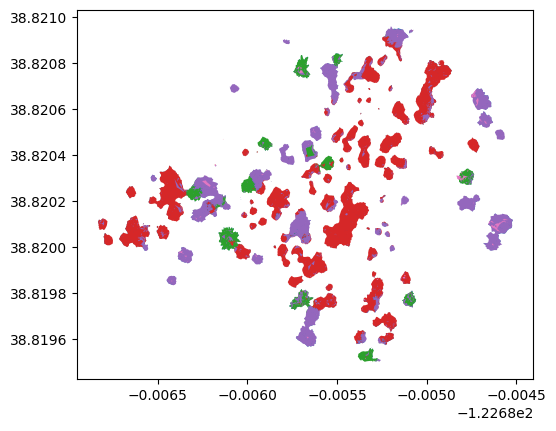

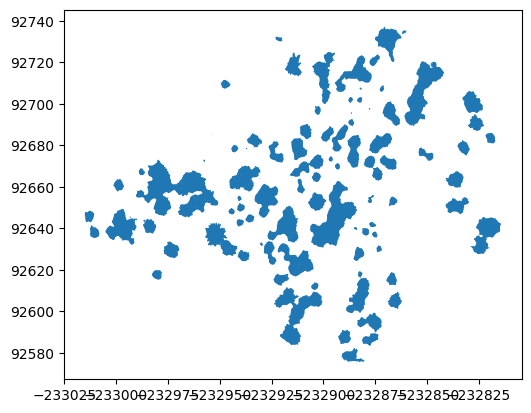

In [5]:
df = gpd.read_file(PREDICTED_VECTOR_LABELS_FILE)
df.plot("class_ID", cmap="tab10", vmin=-0.5, vmax=9.5)

class_fractions, IDs_in_original, unique_class_names = get_overlap_vector(
    unlabeled_df=LABELS_FILENAME,
    classes_df = PREDICTED_VECTOR_LABELS_FILE,
    class_column="class_ID"
)

[[1.86174376e+01 0.00000000e+00 0.00000000e+00 5.13325064e+01
  3.42631984e-01 0.00000000e+00]
 [4.23137049e+00 3.00234616e-02 0.00000000e+00 7.51550894e+00
  2.72474374e-01 0.00000000e+00]
 [5.27084571e+00 1.61376101e-01 0.00000000e+00 1.00821382e+01
  3.57779579e-01 0.00000000e+00]
 [1.25224718e+01 0.00000000e+00 7.75606115e-01 3.23159351e+01
  1.65527857e+00 0.00000000e+00]
 [1.37743069e+01 0.00000000e+00 3.37763971e-01 1.22744441e+00
  3.01542837e+01 0.00000000e+00]
 [1.19468363e+00 0.00000000e+00 4.83379226e-01 2.72838939e+00
  1.12565787e-01 0.00000000e+00]
 [8.16777490e+00 0.00000000e+00 2.86875685e+01 4.31634071e+00
  4.32838260e-01 0.00000000e+00]
 [6.30383776e+00 0.00000000e+00 0.00000000e+00 1.80547655e+01
  3.94806995e-04 0.00000000e+00]
 [4.45677324e+00 0.00000000e+00 0.00000000e+00 1.17444427e+01
  0.00000000e+00 0.00000000e+00]
 [8.30056290e+00 0.00000000e+00 0.00000000e+00 1.60921700e+01
  4.54972671e+00 0.00000000e+00]
 [8.24801617e+00 0.00000000e+00 4.58754061e+00 1.4

/ofo-share/repos-david/conda/envs/MVMT-stable/lib/python3.9/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<Axes: >

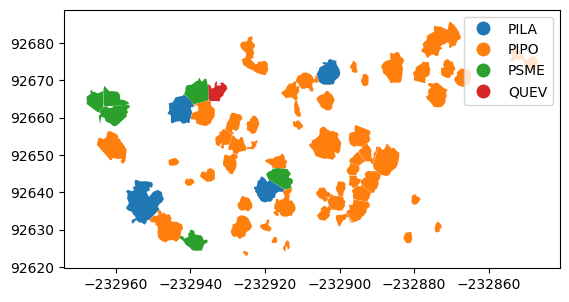

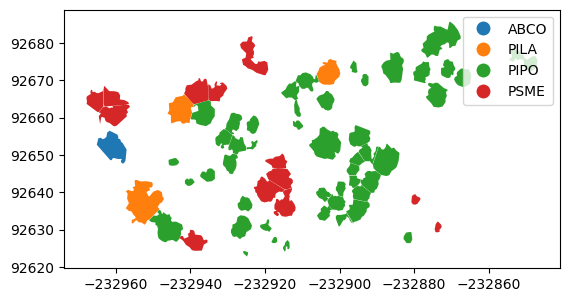

In [6]:
print(class_fractions)
print(IDs_in_original)
print(unique_class_names)
pred_IDs = np.argmax(class_fractions, axis=1)

pred_IDs = [int(unique_class_names[i]) for i in pred_IDs]
pred_class = [IDs_TO_LABELS[pred_ID] for pred_ID in pred_IDs]

# Load the data
gdf = gpd.read_file(LABELS_FILENAME)
site_gdf = gdf.iloc[IDs_in_original]
site_gdf["pred_class"] = pred_class
print("Ground truth")
site_gdf.plot(LABELS_COLUMN, legend=True, vmin=-0.5, vmax=9.5)
print("Predicted")
site_gdf.plot("pred_class", legend=True, vmin=-0.5, vmax=9.5)

GT classes ['PIPO', 'PIPO', 'PIPO', 'PIPO', 'PIPO', 'PIPO', 'PILA', 'PIPO', 'PIPO', 'PIPO', 'PIPO', 'PIPO', 'QUEV', 'PIPO', 'PSME', 'PIPO', 'PIPO', 'PSME', 'PSME', 'PILA', 'PIPO', 'PSME', 'PIPO', 'PIPO', 'PIPO', 'PIPO', 'PIPO', 'PIPO', 'PIPO', 'PIPO', 'PIPO', 'PIPO', 'PIPO', 'PIPO', 'PIPO', 'PIPO', 'PIPO', 'PIPO', 'PIPO', 'PIPO', 'PSME', 'PIPO', 'PIPO', 'PIPO', 'PILA', 'PIPO', 'PIPO', 'PIPO', 'PIPO', 'PILA', 'PIPO', 'PIPO', 'PIPO', 'PIPO', 'PIPO', 'PIPO', 'PIPO', 'PIPO', 'PIPO', 'PIPO', 'PIPO', 'PIPO', 'PSME', 'PIPO', 'PIPO']
Pred classes ['PIPO', 'PIPO', 'PIPO', 'PIPO', 'PSME', 'PIPO', 'PILA', 'PIPO', 'PIPO', 'PIPO', 'PIPO', 'PIPO', 'PSME', 'PIPO', 'PSME', 'PIPO', 'PIPO', 'PSME', 'PSME', 'PILA', 'PIPO', 'PSME', 'PIPO', 'PIPO', 'PIPO', 'PIPO', 'PIPO', 'PIPO', 'PIPO', 'PIPO', 'PIPO', 'ABCO', 'PIPO', 'PIPO', 'PSME', 'PIPO', 'PIPO', 'PIPO', 'PIPO', 'PIPO', 'PSME', 'PIPO', 'PIPO', 'PIPO', 'PSME', 'PIPO', 'PIPO', 'PIPO', 'PSME', 'PILA', 'PIPO', 'PIPO', 'PSME', 'PIPO', 'PIPO', 'PIPO', 'PIPO'

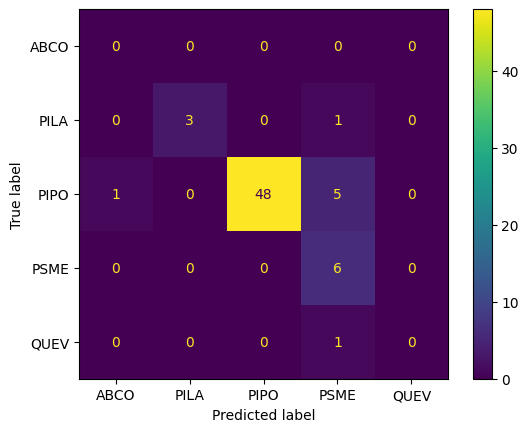

In [7]:
gt_list = site_gdf[LABELS_COLUMN].tolist()
pred_list = site_gdf["pred_class"].tolist()
print(f"GT classes {gt_list}")
print(f"Pred classes {pred_list}")

cf, classes, accuracy = compute_and_show_cf(pred_labels=pred_list, gt_labels=gt_list)
np.save(NUMPY_EXPORT_CONFUSION_MATRIX_FILE, cf)

# Ground truth classes

Loading transform to EPSG:4326


INFO:mesh_140390496000512:Loading transform to EPSG:4326


Loading mesh


INFO:mesh_140390496000512:Loading mesh


Reading the mesh


INFO:mesh_140390496000512:Reading the mesh


Selecting an ROI from mesh


INFO:mesh_140390496000512:Selecting an ROI from mesh


Standardizing ROI


INFO:mesh_140390496000512:Standardizing ROI


Dissolving ROI


INFO:mesh_140390496000512:Dissolving ROI


Setting CRS and buffering ROI


INFO:mesh_140390496000512:Setting CRS and buffering ROI


Dissolving buffered ROI


INFO:mesh_140390496000512:Dissolving buffered ROI


Extracting verts for dataframe


INFO:mesh_140390496000512:Extracting verts for dataframe


Checking intersection of verts with ROI


INFO:mesh_140390496000512:Checking intersection of verts with ROI


Extracting points from pyvista mesh


INFO:mesh_140390496000512:Extracting points from pyvista mesh


Extraction surface from subset mesh


INFO:mesh_140390496000512:Extraction surface from subset mesh


Extracting faces from mesh


INFO:mesh_140390496000512:Extracting faces from mesh


Loading texture


INFO:mesh_140390496000512:Loading texture


Could not read texture as a scalar from the pyvista mesh


Could not read texture as a numpy file


Sampling values from raster /ofo-share/scratch-david/organized-str-disp-MVMT-experiments/per_site_processing/valley/02_photogrammetry/exports/dtms/valley.tif: 100%|██████████| 134102/134102 [00:05<00:00, 23620.88it/s]


This method will be deprecated in favor of get_IDs_to_labels since it doesn't handle non-sequential indices


/ofo-share/repos-david/conda/envs/MVMT-stable/lib/python3.9/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

No module named 'trame.ui.vuetify'

Falling back to a static output.
  warnings.warn(


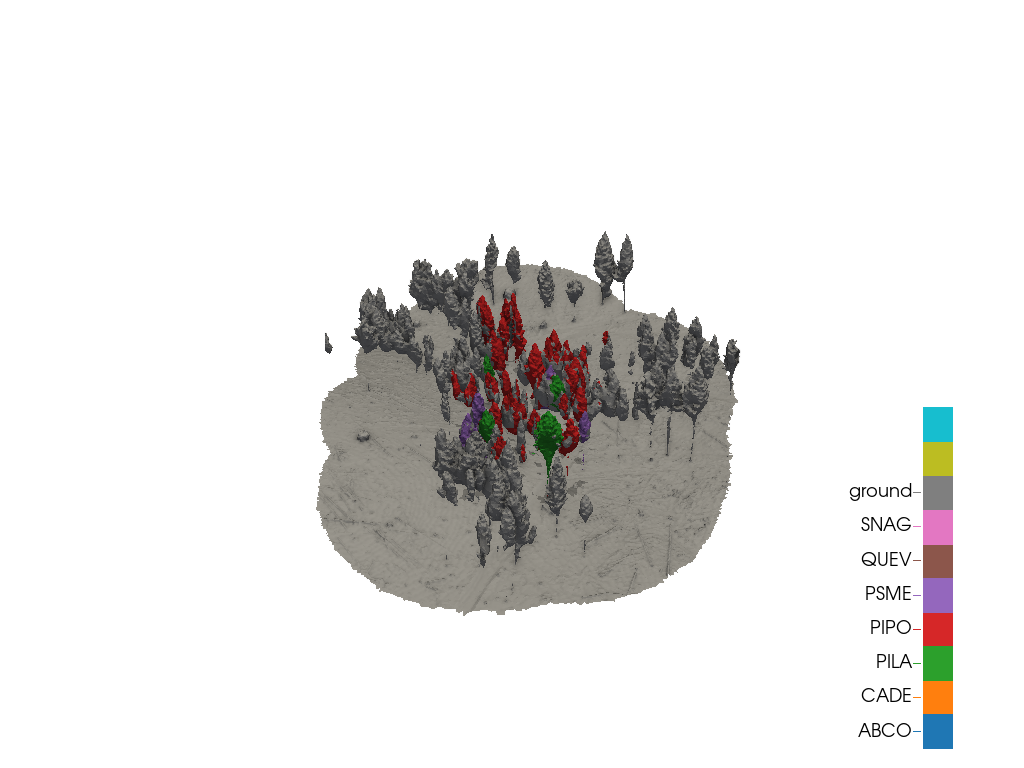

In [8]:
mesh = TexturedPhotogrammetryMesh(
    MESH_FILENAME,
    transform_filename=CAMERAS_FILENAME,
    texture=LABELS_FILENAME,
    texture_column_name=LABELS_COLUMN,
    ROI=LABELS_FILENAME,
    ROI_buffer_meters=BUFFER_RADIUS_METERS,
)
mesh.label_ground_class(
    height_above_ground_threshold=HEIGHT_ABOVE_GROUND_THRESH,
    DTM_file=DTM_FILE,
    set_mesh_texture=True,
)
mesh.vis(force_xvfb=True)

# Predicted classes

Loading transform to EPSG:4326


INFO:mesh_140390490559152:Loading transform to EPSG:4326


Loading mesh


INFO:mesh_140390490559152:Loading mesh


Reading the mesh


INFO:mesh_140390490559152:Reading the mesh


Selecting an ROI from mesh


INFO:mesh_140390490559152:Selecting an ROI from mesh


Standardizing ROI


INFO:mesh_140390490559152:Standardizing ROI


Dissolving ROI


INFO:mesh_140390490559152:Dissolving ROI


Setting CRS and buffering ROI


INFO:mesh_140390490559152:Setting CRS and buffering ROI


Dissolving buffered ROI


INFO:mesh_140390490559152:Dissolving buffered ROI


Extracting verts for dataframe


INFO:mesh_140390490559152:Extracting verts for dataframe


Checking intersection of verts with ROI


INFO:mesh_140390490559152:Checking intersection of verts with ROI


Extracting points from pyvista mesh


INFO:mesh_140390490559152:Extracting points from pyvista mesh


Extraction surface from subset mesh


INFO:mesh_140390490559152:Extraction surface from subset mesh


Extracting faces from mesh


INFO:mesh_140390490559152:Extracting faces from mesh


Loading texture


INFO:mesh_140390490559152:Loading texture


Could not read texture as a scalar from the pyvista mesh


This method will be deprecated in favor of get_IDs_to_labels since it doesn't handle non-sequential indices


/ofo-share/repos-david/conda/envs/MVMT-stable/lib/python3.9/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

No module named 'trame.ui.vuetify'

Falling back to a static output.
  warnings.warn(


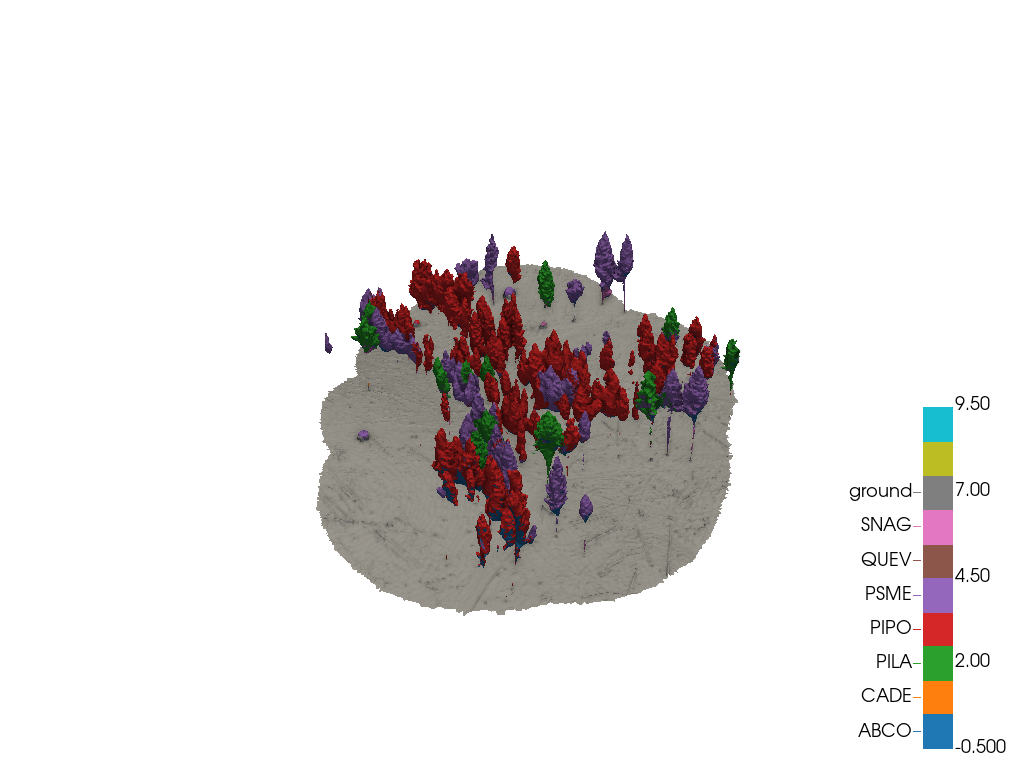

In [9]:
mesh = TexturedPhotogrammetryMesh(
    MESH_FILENAME,
    transform_filename=CAMERAS_FILENAME,
    texture=NUMPY_EXPORT_FACES_TEXTURE_FILE,
    IDs_to_labels=IDs_TO_LABELS,
    ROI=LABELS_FILENAME,
    ROI_buffer_meters=BUFFER_RADIUS_METERS,
)
mesh.vis(force_xvfb=True)

# Colored mesh

Loading transform to EPSG:4326


INFO:mesh_140390490003728:Loading transform to EPSG:4326


Loading mesh


INFO:mesh_140390490003728:Loading mesh


Reading the mesh


INFO:mesh_140390490003728:Reading the mesh


Selecting an ROI from mesh


INFO:mesh_140390490003728:Selecting an ROI from mesh


Standardizing ROI


INFO:mesh_140390490003728:Standardizing ROI


Dissolving ROI


INFO:mesh_140390490003728:Dissolving ROI


Setting CRS and buffering ROI


INFO:mesh_140390490003728:Setting CRS and buffering ROI


Dissolving buffered ROI


INFO:mesh_140390490003728:Dissolving buffered ROI


Extracting verts for dataframe


INFO:mesh_140390490003728:Extracting verts for dataframe


Checking intersection of verts with ROI


INFO:mesh_140390490003728:Checking intersection of verts with ROI


Extracting points from pyvista mesh


INFO:mesh_140390490003728:Extracting points from pyvista mesh


Extraction surface from subset mesh


INFO:mesh_140390490003728:Extraction surface from subset mesh


Extracting faces from mesh


INFO:mesh_140390490003728:Extracting faces from mesh


Loading texture


INFO:mesh_140390490003728:Loading texture
/ofo-share/repos-david/conda/envs/MVMT-stable/lib/python3.9/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

No module named 'trame.ui.vuetify'

Falling back to a static output.
  warnings.warn(


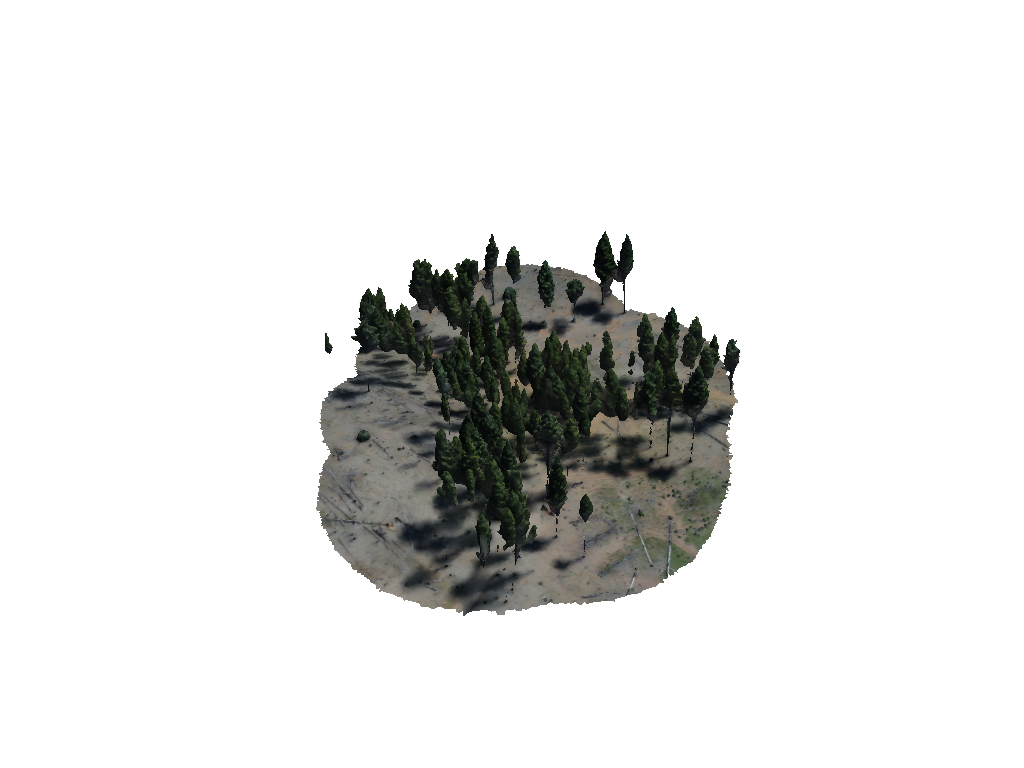

In [10]:
mesh = TexturedPhotogrammetryMesh(
    MESH_FILENAME,
    transform_filename=CAMERAS_FILENAME,
    ROI=LABELS_FILENAME,
    ROI_buffer_meters=BUFFER_RADIUS_METERS,
)
mesh.vis(force_xvfb=True)